In [284]:
import scipy.misc as misc
from matplotlib import pyplot as plt
import matplotlib.colors
import numpy as np
import imageio
import cv2
%matplotlib inline

In [336]:
def wavelength_rgb(wavelength, gamma = 1.):
    """
    """
    wavelength = float(wavelength)
    
    if (wavelength >= 380) and (wavelength <= 750):
        A = 0.6
    else:
        A = 0.5
        
    if (wavelength >= 380) and (wavelength <= 450):           # Violet
        attenuation = 0.3 + 0.7 * (wavelength - 380) / (450 - 380)
        R = ((-(wavelength - 450) / (450 - 380)) * attenuation) ** gamma
        G = 0.0
        B = (1.0 * attenuation) ** gamma
    
    elif (wavelength > 450) and (wavelength <= 495):           # Blue
        R = 0.0
        G = ((wavelength - 450) / (495 - 450)) ** gamma
        B = 1.0
    elif (wavelength > 495) and (wavelength <= 570):       #Green
        R = 0.0
        G = 1.0
        B = (-(wavelength - 570) / (570 - 495)) ** gamma
    elif (wavelength > 570) and (wavelength <= 590):       #Yellow
        R = ((wavelength - 570) / (590 - 570)) ** gamma
        G = 1.0
        B = 0.0
    elif (wavelength > 590) and (wavelength <= 620):       #Orange
        R = 1.0
        G = (-(wavelength - 620) / (620 - 590)) ** gamma
        B = 0.0
    elif (wavelength > 620) and (wavelength <= 750):       #Red
        attenuation = 0.3 + 0.7 * (750 - wavelength) / (750 - 620)
        R = (1.0 * attenuation) ** gamma
        G = 0.0
        B = 0.0
    else:
        R, G, B = 0., 0., 0.
    
    return (R, G, B, A)

def calibrate(pixels, lambdas, img, blue=470, red=623):
    """
    Assumming linear behavior when having 2 values for wavelength
    lambda = a * x + lambda_0
    """

    points = [(pixels[0], lambdas[0]), (pixels[1], lambdas[1])]
    X, Y = zip(*points)
    X0 = np.ones(len(X))
    
    matrix = np.vstack([X, X0]).T
    a, Y0 = np.linalg.lstsq(matrix, Y, rcond=None)[0]
    
    wavelength = []
    
    for x in range(img.shape[1]):
        y = a * x + Y0
        wavelength.append(y)
    
    wavelength.sort()
    
    return wavelength

def plot_spectrum(wavelength, img, leds=False):
    """
    plot
    """
    
    spectrum = np.empty((0))
    spectrum_leds = np.empty((0))
    I0 = []
    I0_leds = []
    
    for i in range(img.shape[1]):
        if leds:
            [r_leds, g_leds, b_leds] = img[20, i]
            I_leds = int(r_leds) + int(g_leds) + (b_leds)
            I0_leds.append(I_leds)
            spectrum_leds = np.append(spectrum_leds, I_leds)
            
        [r, g, b] = img[100, i]
        I = int(r) + int(g) + int(b)
        I0.append(I)
        spectrum = np.append(spectrum, I)
    
    clim=(350,780)
    norm = plt.Normalize(*clim)
    wl = np.arange(clim[0],clim[1]+1,2)
    colorlist = list(zip(norm(wl),[wavelength_rgb(w) for w in wl]))
    spectralmap = matplotlib.colors.LinearSegmentedColormap.from_list("spectrum", colorlist)
    
    plt.figure()
    plt.plot(wavelength, (spectrum - min(spectrum)) / max(I0))
    if leds:
        plt.plot(wavelength, (spectrum_leds - min(spectrum_leds)) / max(I0_leds), 'r+')
    
    mesh_y = np.linspace(0, 1, 100)
    X,Y = np.meshgrid(wavelength, mesh_y)
    extent=(np.min(wavelength), np.max(wavelength), np.min(mesh_y), np.max(mesh_y))
    plt.imshow(X, clim=clim,  extent=extent, cmap=spectralmap, aspect='auto')
    
    plt.xlabel(r"$\lambda$ [nm]")
    plt.ylabel(r"$I/I_0$")
    plt.fill_between(wavelength, (spectrum - min(spectrum)) / max(I0), 1, color='w')
    plt.show()

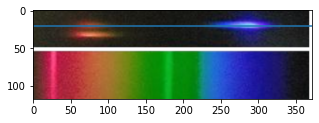

In [337]:
img2 = cv2.imread('espectro2.png')


plt.figure(figsize=(5,5))
plt.imshow(img2)
plt.axhline(y=20)
plt.show()

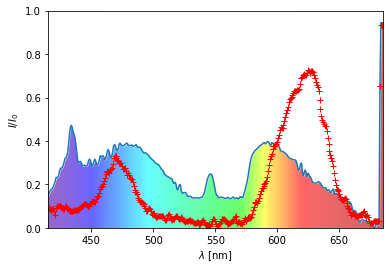

In [338]:
WL = calibrate([25, 180], [433, 546], img2)

plot_spectrum(WL, img2, leds=True)